## Imports

In [ ]:
import json
import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import PolynomialFeatures

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import RandomUniform, RandomNormal, HeNormal, GlorotUniform, Constant, Zeros
from keras.optimizers import SGD
from tensorflow.keras.regularizers import l2


dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search, random_search, tuning_search_top_configs
from training.solver import Solver

%load_ext autoreload
%autoreload 2

# Neural Networks
In this notebook we implement and test a custom (feed-forward) Neural Network w.r.t. the tasks at hand, i.e. the three MONK's problem and the CUP dataset. 

The employed optimizer is **Stochastic Gradient Descent (SGD) with mini-batch**.

Specifically:
- **get_nn_classifier(...)**: defines the (SGD) NN classifier for the MONK's problems;
- **get_nn_sgd_regressor(...)**: defines the (SGD) NN regressor for the CUP dataset.

## Settings

In [ ]:
MODEL_NAME = 'NN-SGD'
INTERNAL_TEST_SPLIT = 0.1 # internal test split percentage
RANDOM_STATE = 128 # reproducibility
N_SPLITS = 5 # cross-validation
POLY_DEGREE = 3 # polynomial features pre-processing

## Path

In [ ]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [ ]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

## Model

In [ ]:
def get_nn_classifier(hparams):
    """Returns a NN with SGD classifier.
    
    Args:
        - hparams: a set of hyper-parameters
    """
    
    initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
    
    model = Sequential([
        Dense(hparams['h_dim'], activation='tanh', input_shape=(17,), kernel_initializer=initializer),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(hparams['reg']))
    ])
    
    optimizer = SGD(learning_rate=hparams['lr'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    
    model.hparams = hparams
    return model

## Training - Testing

In [ ]:
model_m1 = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0.0})
solver = Solver(model_m1, x_dev_m1, y_dev_m1, x_test_m1, y_test_m1, target='accuracy')
solver.train(epochs=400, patience=None, batch_size=16)

In [ ]:
solver.plot_history(results_dir + '/MONK1/history', 'MSE', 'Accuracy')

In [ ]:
print('-- DEVELOPMENT --')
mse_dev_m1, acc_dev_m1 = model_m1.evaluate(x_dev_m1, y_dev_m1)
print(f'Accuracy: {acc_dev_m1:.4f} - MSE: {mse_dev_m1:.4f}')

In [ ]:
print('-- TEST --')
mse_test_m1, acc_test_m1 = model_m1.evaluate(x_test_m1, y_test_m1)
print(f'Accuracy: {acc_test_m1:.4f} - MSE: {mse_test_m1:.4f}')

## Store results

In [ ]:
report_m1 = {
    'dev': {'accuracy': acc_dev_m1, 'mse': mse_dev_m1},
    'test': {'accuracy': acc_test_m1, 'mse': mse_test_m1}
}

store_monk_result(results_dir + '/MONK1/', model_m1.hparams, report_m1)

# MONK-2

In [42]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

## Training - Testing

In [ ]:
model_m2 = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m2, x_dev_m2, y_dev_m2, x_test_m2, y_test_m2, target='accuracy')
solver.train(epochs=400, patience=None, batch_size=64)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\matte\\Desktop\\Jupyter Workspace\\ML-B/results/NN-SGD/tgt/history.png'

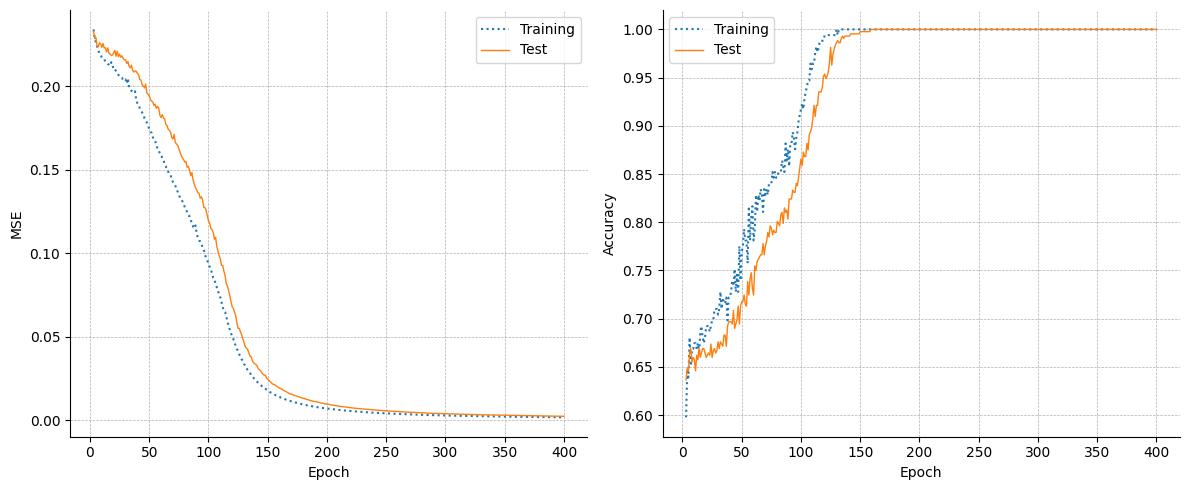

In [55]:
solver.plot_history(results_dir + '/MONK2/history','MSE', 'Accuracy')

In [53]:
print('-- DEVELOPMENT --')
mse_dev_m2, acc_dev_m2 = model_m2.evaluate(x_dev_m2, y_dev_m2)
print(f'Accuracy: {acc_dev_m2:.4f} - MSE: {mse_dev_m2:.4f}')

-- DEVELOPMENT --
6/6 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000
Accuracy: 1.0000 - MSE: 0.0017


In [54]:
print('-- TEST --')
mse_test_m2, acc_test_m2 = model_m2.evaluate(x_test_m2, y_test_m2)
print(f'Accuracy: {acc_test_m2:.4f} - MSE: {mse_test_m2:.4f}')

-- TEST --
14/14 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Accuracy: 1.0000 - MSE: 0.0023


## Store results

In [ ]:
report_m2 = {
    'dev': {'accuracy': acc_dev_m2, 'mse': mse_dev_m2},
    'test': {'accuracy': acc_test_m2, 'mse': mse_test_m2}
}

store_monk_result(results_dir + '/MONK2/', model_m2.hparams, report_m2)

# MONK-3 (no regularization)

In [ ]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

## Training - Testing

In [ ]:
model_m3 = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0})
solver = Solver(model_m3, x_dev_m3, y_dev_m3, x_test_m3, y_test_m3, target='accuracy')
solver.train(epochs=300, patience=None, batch_size=128)

In [ ]:
solver.plot_history(results_dir + '/MONK3/history','MSE', 'Accuracy')

In [ ]:
print('-- DEVELOPMENT --')
mse_dev_m3, acc_dev_m3 = model_m3.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3:.4f} - MSE: {mse_dev_m3:.4f}')

In [ ]:
print('-- TEST --')
mse_test_m3, acc_test_m3 = model_m3.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3:.4f} - MSE: {mse_test_m3:.4f}')

## Store results

In [ ]:
report_m3 = {
    'dev': {'accuracy': acc_dev_m3, 'mse': mse_dev_m3},
    'test': {'accuracy': acc_test_m3, 'mse': mse_test_m3}
}

store_monk_result(results_dir + '/MONK3/', model_m3.hparams, report_m3)

# MONK-3 (with regularization)
MONK3 when setting some regularization value.

## Training - Testing

In [ ]:
model_m3_reg = get_nn_classifier(hparams={'lr': 0.6, 'h_dim': 4, 'reg': 0.001})
solver = Solver(model_m3_reg, x_dev_m3, y_dev_m3,  x_test_m3, y_test_m3, target='accuracy')
solver.train(epochs=300, patience=None, batch_size=128)

In [ ]:
solver.plot_history(results_dir + '/MONK3-reg/history','MSE', 'Accuracy')

In [ ]:
print('-- DEVELOPMENT --')
mse_dev_m3_reg, acc_dev_m3_reg = model_m3_reg.evaluate(x_dev_m3, y_dev_m3)
print(f'Accuracy: {acc_dev_m3_reg:.4f} - MSE: {mse_dev_m3_reg:.4f}')

In [ ]:
print('-- TEST --')
mse_test_m3_reg, acc_test_m3_reg = model_m3_reg.evaluate(x_test_m3, y_test_m3)
print(f'Accuracy: {acc_test_m3_reg:.4f} - MSE: {mse_test_m3_reg:.4f}')

## Store results

In [ ]:
report_m3_reg = {
    'dev': {'accuracy': acc_dev_m3_reg, 'mse': mse_dev_m3_reg},
    'test': {'accuracy': acc_test_m3_reg, 'mse': mse_test_m3_reg}
}

store_monk_result(results_dir + '/MONK3-reg/', model_m3_reg.hparams, report_m3_reg)

# CUP

In [ ]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [ ]:
@keras.utils.register_keras_serializable()
def mean_euclidean_error(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Utility function to compute the Mean Euclidean Error (MEE) between 
    true and predicted values for a tensorflow model. 
    Return the MEE score as a tensor.

    Required arguments:
    - y_true: array containing true values (ground truth).
    - y_pred: array containing predicted values.
    """
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)))

## Dev - Internal Test Split 
The development dataset is split between training and internal test ($90-10$).

In [ ]:
# Split dev data into train - internal test
x_train_cup, x_internal_test_cup, y_train_cup, y_internal_test_cup = train_test_split(
    x_dev_cup, 
    y_dev_cup, 
    test_size=INTERNAL_TEST_SPLIT, 
    random_state=128
)

## Polynomial features pre-processing
We create a version of our dataset to which PolynoMialFeatures pre-processing is applied with a fixed degree.

In [ ]:
# --- COMMENT TO USE NON-ENCHANED DATASET --- 
# Polynomial features pre-processing
poly = PolynomialFeatures(degree=POLY_DEGREE)
x_train_cup = poly.fit_transform(x_train_cup)
x_internal_test_cup = poly.transform(x_internal_test_cup)
x_test_cup = poly.transform(x_test_cup)

# NN-SGD (mb)

In [ ]:
def get_nn_sgd_regressor(hparams: dict, in_dim: int):
    """Returns a NN with SGD regressor.
    
    Args:
        - hparams: a set of hyper-parameters
        - in_dim: input dimension [1]
    """
    
    if hparams['activation'] == 'tanh':
        initializer = GlorotUniform(seed=RANDOM_STATE) # Glorot (Xavier)
        bias_initializer = Zeros()
    elif hparams['activation'] == 'ReLU':
        initializer = HeNormal(seed=RANDOM_STATE) # He (Kaiming)
        bias_initializer = Constant(0.1)
        
    reg = l2(hparams['reg'])
        
    model = Sequential()
    model.add(Dense(
        hparams['h_dim'], 
        activation=hparams['activation'], 
        input_shape=(in_dim,), 
        kernel_regularizer=l2(hparams['reg']),
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    h_dim = hparams['h_dim']
    for i in range(hparams['n_layers'] - 1):
        model.add(
            Dense(
                h_dim, 
                activation=hparams['activation'],
                kernel_regularizer=l2(hparams['reg']),
                kernel_initializer=initializer,
                bias_initializer=bias_initializer))
        h_dim //= 2
        
    model.add(Dense(
        3, 
        activation='linear', 
        kernel_regularizer=l2(hparams['reg']), 
        kernel_initializer=initializer,
        bias_initializer=bias_initializer))

    optimizer = SGD(learning_rate=hparams['lr'], momentum=hparams['momentum'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[mean_euclidean_error])
    return model

## Hyper-parameters Tuning
A common approach is to start with a coarse search across a wide range of values to find promising sub-ranges of our parameter space. Then, you would zoom into these ranges and perform another search to fine-tune the configurations.

Here, we proceed as follows:
1. (coarse) Grid-search across a wide range of hyper-paramaters and values;
2. (fine-tune) Random-search into zoomed intervals w.r.t. best configuration found by grid-search.

Then, we perform a single run of grid-search and random-search with the respectively best configurations while taking into account a PolynomialFeatures pre-processing with fixed degree. The best configurations that will be used for final re-training and evaluation on internal test is the one with the best mean MEE on the validation cross-validation.

Note that, tuning of the polynomial degree wasn't performed because it would be very expensive. Thus, we simply decided to use a fixed degree value.

### Grid Search

In [ ]:
grid_search_spaces_cup = {
    'lr': [0.01, 0.001, 0.0001],
    'n_layers': [2, 3],
    'h_dim': [32, 64, 128],
    'activation': ['tanh'],
    'reg': [0.01, 0.001],
    'momentum': [0.9],
    'batch_size': [32, 64, 128],
}

In [ ]:
# Grid search (coarse)
best_model_coarse, best_config_coarse, results_coarse = grid_search(
    get_nn_sgd_regressor,
    x_train_cup.shape[1],
    x_train_cup,
    y_train_cup,
    grid_search_spaces_cup, 
    target='val_mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    EPOCHS=800, 
    PATIENCE=50
)

### Random Search

In [ ]:
# set new intervals for fine-tune random search
lr = best_config_coarse['lr']
n_layers = best_config_coarse['n_layers']
h_dim = best_config_coarse['h_dim']
activation = best_config_coarse['activation']
reg = best_config_coarse['reg']
momentum = best_config_coarse['momentum']
batch_size = best_config_coarse['batch_size']

In [ ]:
random_search_spaces_cup = {
    'lr': ([0.01, 0.004], 'float'),
    'n_layers': ([2, 3], 'item'),
    'h_dim': ([64, 80, 100], 'item'),
    'activation': (['tanh'], 'item'),
    'reg': ([0.001], 'item'),
    'momentum': ([0.93, 0.98], 'float'),
    'batch_size': ([32], 'item'),
}

In [ ]:
# Random search (fine-tune)
best_model_finetune, best_config_finetune, results_finetune = random_search(
    get_nn_sgd_regressor,
    x_train_cup.shape[1],
    x_train_cup,
    y_train_cup,
    random_search_spaces_cup, 
    target='val_mean_euclidean_error', 
    N_SPLITS=N_SPLITS,
    NUM_SEARCH=20,
    EPOCHS=800, 
    PATIENCE=50
)

### Save tuning results

In [ ]:
mee_coarse = best_config_coarse['val_mean_euclidean_error']
mee_finetune = best_config_finetune['val_mean_euclidean_error']

best_config_cup = best_config_finetune if mee_finetune < mee_coarse else best_config_coarse

In [ ]:
# Store grid-search
best_config_coarse['n_layers'] = int(best_config_coarse['n_layers'])
best_config_coarse['h_dim'] = int(best_config_coarse['h_dim'])
best_config_coarse['batch_size'] = int(best_config_coarse['batch_size'])
with open(results_dir + '/CUP/grid_search.json', 'w') as outf:
    json.dump(best_config_coarse, outf, indent=4)
    
# Store random-search
best_config_finetune['n_layers'] = int(best_config_finetune['n_layers'])
best_config_finetune['h_dim'] = int(best_config_finetune['h_dim'])
best_config_finetune['batch_size'] = int(best_config_finetune['batch_size'])
with open(results_dir + '/CUP/random_search.json', 'w') as outf:
    json.dump(best_config_finetune, outf, indent=4)

## Training and Internal test assessment
Let's perform a re-training of our model on the entire training/validation set. In this way, we're able to leverage the entire training/validation data (early stopping is applied w.r.t. the train MEE). Finally, predict on the (untouched) internal test to perform model assessment and estimate our performance on the blind test set.

Note that, in this phase, we don't use the internal test in any way (i.e., no training and no validation). We only estimate its errors and plot its curves.

In [ ]:
# --- UNCOMMENT TO TEST ---
# Best (tuning) configuration
# Best configuration
best_config_cup = {
    'lr': 0.00035,
    'h_dim': 100,
    'n_layers': 3,
    'activation': 'tanh',
    'reg': 0.001,
    'momentum': 0.95, 
    'batch_size': 32,
}

In [ ]:
# Train to plot learning curves
model_nn_cup = get_nn_sgd_regressor(best_config_cup, x_train_cup.shape[1])
solver = Solver(model_nn_cup, x_train_cup, y_train_cup, x_internal_test_cup, y_internal_test_cup, target='mean_euclidean_error')
solver.train(epochs=800, patience=50)

In [ ]:
# Store learning curves
solver.plot_history(results_dir + '/CUP/history_poly', loss='MSE', metric='MEE')

## Training average

To obtain a more accurate estimate on the internal test (and thus on the blind test), we perform 5 trials with the exact same setting, and then take the average.
In this phase, we don't use the internal test in any way (i.e., no training and no validation). We only predict and plot its curves.

Specifically, we train execute $<N\_TRIALS>$ trials of training.

In [ ]:
N_TRIALS = 5

# Keep track of the trials results
train_preds_arr = np.zeros((N_TRIALS, 900, 3))
internal_test_preds_arr = np.zeros((N_TRIALS, 100, 3))
test_preds_arr = np.zeros((N_TRIALS, 900, 3))

In [ ]:
# Perform 5 training trials
for i in range(N_TRIALS):
    # Train (early stopping on train MEE)
    model_nn_cup = get_nn_sgd_regressor(best_config_cup, x_train_cup.shape[1])
    solver = Solver(model_nn_cup, x_train_cup, y_train_cup, x_internal_test_cup, y_internal_test_cup, target='mean_euclidean_error')
    solver.train(epochs=800, patience=50)

    # Store train predictions
    train_preds_arr[i] = model_nn_cup.predict(x_train_cup)
    # Store internal test predictions
    internal_test_preds_arr[i] = model_nn_cup.predict(x_internal_test_cup)
    # Blind test predictions
    test_preds_arr[i] = model_nn_cup.predict(x_test_cup)

In [ ]:
print('-- TRAINING (MEAN 5 TRIALS) --')
loss_train_mean, mee_train_mean = mean_squared_error(y_train_cup, np.mean(train_preds_arr, axis=0)), mean_euclidean_error(y_train_cup, np.mean(train_preds_arr, axis=0))
print(f'Mean Loss (MSE): {loss_train_mean:.4f} - Mean MEE: {mee_train_mean:.4f}')

In [ ]:
print('-- INTERNAL TEST (MEAN 5 TRIALS) --')
loss_internal_test_mean, mee_internal_test_mean = mean_squared_error(y_internal_test_cup, np.mean(internal_test_preds_arr, axis=0)), mean_euclidean_error(y_internal_test_cup, np.mean(internal_test_preds_arr, axis=0))
print(f'Mean Loss (MSE): {loss_internal_test_mean:.4f} -  Mean MEE: {mee_internal_test_mean:.4f}')

In [ ]:
# Blind test set predictions
mean_preds_cup = np.mean(test_preds_arr, axis=0)

### Store result

In [ ]:
# Store report
report_nn_mean = {
    'train': {
        'mean_mse': loss_train_mean, 
        'mean_mee': mee_train_mean,
    },
    'internal_test': {
        'mean_mse': loss_internal_test_mean, 
        'mean_mee': mee_internal_test_mean,
    }
}

store_cup_result(results_dir + '/CUP/mean_5_', best_config_cup, report_nn_mean, mean_preds_cup, is_poly=True)

Store the train and internal test (mean) predictions so that they can be used for the estimate of the ensembles

In [ ]:
# Store train mean predictions
with open(results_dir + '/CUP/mean_5_train_preds_poly.csv', 'w') as outf:
    # Team Info
    outf.write("# Matteo Pinna, Leonardo Caridi, Marco Sanna\n")
    outf.write("# ACD-TEAM\n")
    outf.write("# ML-CUP23 v2\n")
    outf.write("# 20/01/2024\n")

    # Writing predictions
    for i, pred in enumerate(np.mean(train_preds_arr, axis=0), 1):
        outf.write(f"{i},{','.join(map(str, pred))}\n")
        
# Store internal test mean predictions
with open(results_dir + '/CUP/mean_5_internal_test_preds_poly.csv', 'w') as outf:
    # Team Info
    outf.write("# Matteo Pinna, Leonardo Caridi, Marco Sanna\n")
    outf.write("# ACD-TEAM\n")
    outf.write("# ML-CUP23 v2\n")
    outf.write("# 20/01/2024\n")

    # Writing predictions
    for i, pred in enumerate(np.mean(internal_test_preds_arr, axis=0), 1):
        outf.write(f"{i},{','.join(map(str, pred))}\n")

# Final re-training
Since the test error has already been estimated by leveraging the (untouched) internal test, we now perform a final re-training with all the development data. This does not violate the rules, since the internal test is not (and has never) been used for any model selection.

Thus, we train on the entire development data, i.e. $90$ train/val + $10$ internal test. Early stopping is w.r.t. the MEE.

In [ ]:
# Apply polynomial to the entire development set
x_dev_cup = poly.transform(x_dev_cup)

# Keep track of the trials results
dev_preds_arr = np.zeros((N_TRIALS, 1000, 3))
final_blind_test_preds_arr = np.zeros((N_TRIALS, 900, 3))

This time - since the internal test estimate has already been performed - we're able to use the internal test set either as training data or as validation for the early stopping mechanism.

In [ ]:
# Perform 5 training trials
for i in range(N_TRIALS):
    # Train (early stopping on validation/internal test MEE)
    model_nn_cup = get_nn_sgd_regressor(best_config_cup, x_train_cup.shape[1])
    solver = Solver(model_nn_cup, x_dev_cup, y_dev_cup, target='mean_euclidean_error')
    solver.train(epochs=1000, patience=50)

    # Dev predictions
    dev_preds_arr[i] = model_nn_cup.predict(x_dev_cup)
    # Blind test predictions
    final_blind_test_preds_arr[i] = model_nn_cup.predict(x_test_cup)

In [ ]:
print('-- DEVELOPMENT (MEAN 5 TRIALS) --')
final_train_preds = np.mean(dev_preds_arr, axis=0)
loss_dev_cup_mean, mee_dev_cup_mean = mean_squared_error(y_dev_cup, final_train_preds), mean_euclidean_error(y_dev_cup, final_train_preds)
print(f'Mean Loss (MSE): {loss_dev_cup_mean:.4f} - Mean MEE: {mee_dev_cup_mean:.4f}')

In [ ]:
# Final blind test set predictions
final_blind_test_preds = np.mean(final_blind_test_preds_arr, axis=0)

In [ ]:
# Store final re-training train/dev mean predictions
with open(results_dir + '/CUP/final_train.csv', 'w') as outf:
    # Team Info
    outf.write("# Matteo Pinna, Leonardo Caridi, Marco Sanna\n")
    outf.write("# ACD-TEAM\n")
    outf.write("# ML-CUP23 v2\n")
    outf.write("# 20/01/2024\n")

    # Writing predictions
    for i, pred in enumerate(final_train_preds, 1):
        outf.write(f"{i},{','.join(map(str, pred))}\n")

# Store final blind test mean predictions
with open(results_dir + '/CUP/final_blind_test.csv', 'w') as outf:
    # Team Info
    outf.write("# Matteo Pinna, Leonardo Caridi, Marco Sanna\n")
    outf.write("# ACD-TEAM\n")
    outf.write("# ML-CUP23 v2\n")
    outf.write("# 20/01/2024\n")

    # Writing predictions
    for i, pred in enumerate(final_blind_test_preds, 1):
        outf.write(f"{i},{','.join(map(str, pred))}\n")